<a href="https://colab.research.google.com/github/Bilalhussain0509/FYP_BTD/blob/main/Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2
import matplotlib.image as mpimg
%matplotlib inline
plt.style.use('ggplot')

In [3]:
# Dataset
import zipfile
z = zipfile.ZipFile('/content/DataSet_MRI_scans.zip')

z.extractall()

In [4]:
import os

folder = 'brain_tumor_dataset/yes/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "Y_" + str(count) + ".jpg"
    os.rename(source, destination)
    count += 1

print("all files are renamed in the yes dir")

all files are renamed in the yes dir


In [5]:
folder = 'brain_tumor_dataset/no/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "N_" + str(count) + ".jpg"
    os.rename(source, destination)
    count += 1

print("all files are renamed in the no dir")

all files are renamed in the no dir


In [6]:
listyes = os.listdir("brain_tumor_dataset/yes/")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("brain_tumor_dataset/no/")
number_files_no = len(listno)
print(number_files_no)

155
98


Text(0.5, 1.0, 'Count of Brain Tumor Images')

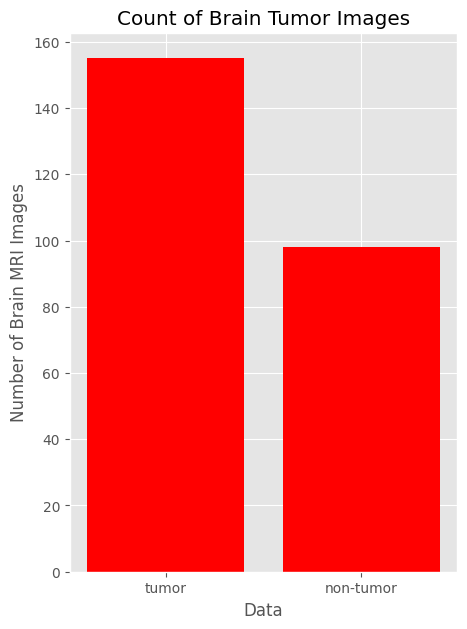

In [7]:
data = {'tumor': number_files_yes, 'non-tumor': number_files_no}
typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))
plt.bar(typex, values, color="red")
plt.xlabel("Data")
plt.ylabel("Number of Brain MRI Images")
plt.title("Count of Brain Tumor Images")


In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [9]:
def timing(sec_elapsed):
    h = int(sec_elapsed / (60*60))
    m = int(sec_elapsed % (60*60) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{s}"

In [10]:
def augmented_data(file_dir, n_generated_samples, save_to_dir):

    data_gen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        brightness_range=(0.3, 1.0),
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )


    for filename in os.listdir(file_dir):
        image_path = os.path.join(file_dir, filename)
        image = cv2.imread(image_path)

        if image is None:
            continue

        image = np.expand_dims(image, axis=0)

        save_prefix = 'aug_' + filename[:-4]

        i = 0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir, save_prefix=save_prefix, save_format="jpg"):
            i += 1
            if i >= n_generated_samples:
                break

In [11]:
import time
start_time = time.time()

yes_path = 'brain_tumor_dataset/yes'
no_path = 'brain_tumor_dataset/no'

augmented_data_path = 'brain_tumor_dataset/'

augmented_data(file_dir = yes_path, n_generated_samples=6, save_to_dir=augmented_data_path+'yes')
augmented_data(file_dir = no_path, n_generated_samples=9, save_to_dir=augmented_data_path+'no')

end_time = time.time()
execution_time = end_time - start_time
print(timing(execution_time))

0:1:43.39105296134949


In [12]:
def data_summary(main_path):
    yes_path = "brain_tumor_dataset/yes"
    no_path = "brain_tumor_dataset/no"

    n_pos = len(os.listdir(yes_path))
    n_neg = len(os.listdir(no_path))

    n = (n_pos + n_neg)

    pos_per = (n_pos*100)/n
    neg_per = (n_neg*100)/n

    print(f"Number of sample: {n}")
    print(f"{n_pos} Number of positive sample in percentage: {pos_per}%")
    print(f"{n_neg} Number of negative sample in percentage: {neg_per}%")

In [13]:
data_summary(augmented_data_path)

Number of sample: 2064
1085 Number of positive sample in percentage: 52.56782945736434%
979 Number of negative sample in percentage: 47.43217054263566%


In [14]:
listyes = os.listdir("brain_tumor_dataset/yes")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("brain_tumor_dataset/no")
number_files_no = len(listno)
print(number_files_no)

1085
979


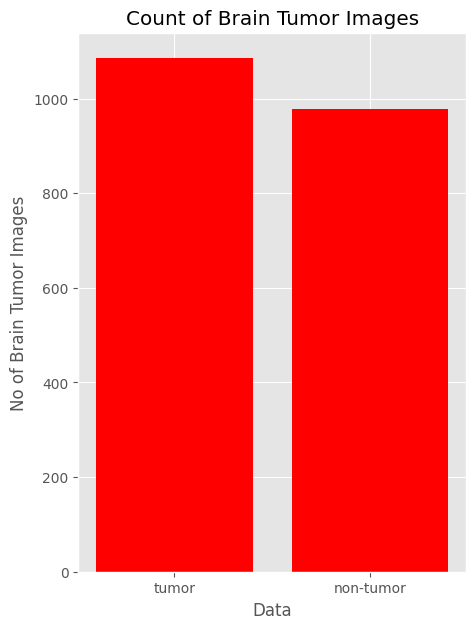

In [15]:
import matplotlib.pyplot as plt

data = {'tumor': number_files_yes, 'non-tumor': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))

plt.bar(typex, values, color="red")

plt.xlabel("Data")
plt.ylabel("No of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

In [16]:
import imutils
def crop_brain_tumor(image, plot=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)

    thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thres =cv2.erode(thres, None, iterations = 2)
    thres = cv2.dilate(thres, None, iterations = 2)

    cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key = cv2.contourArea)

    extLeft = tuple(c[c[:,:,0].argmin()][0])
    extRight = tuple(c[c[:,:,0].argmax()][0])
    extTop = tuple(c[c[:,:,1].argmin()][0])
    extBot = tuple(c[c[:,:,1].argmax()][0])

    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        plt.show()
    return new_image

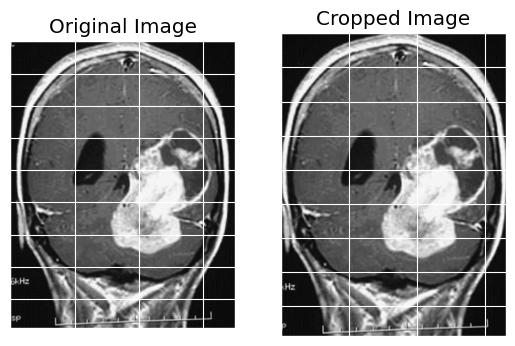

array([[[ 1,  1,  1],
        [ 2,  2,  2],
        [ 2,  2,  2],
        ...,
        [ 1,  1,  1],
        [19, 19, 19],
        [ 1,  1,  1]],

       [[18, 18, 18],
        [ 0,  0,  0],
        [20, 20, 20],
        ...,
        [13, 13, 13],
        [17, 17, 17],
        [14, 14, 14]],

       [[ 1,  1,  1],
        [21, 21, 21],
        [ 4,  4,  4],
        ...,
        [16, 16, 16],
        [ 4,  4,  4],
        [17, 17, 17]],

       ...,

       [[27, 27, 27],
        [ 5,  5,  5],
        [13, 13, 13],
        ...,
        [ 4,  4,  4],
        [24, 24, 24],
        [ 5,  5,  5]],

       [[16, 16, 16],
        [11, 11, 11],
        [ 6,  6,  6],
        ...,
        [ 0,  0,  0],
        [26, 26, 26],
        [ 1,  1,  1]],

       [[ 9,  9,  9],
        [13, 13, 13],
        [ 8,  8,  8],
        ...,
        [18, 18, 18],
        [ 7,  7,  7],
        [ 8,  8,  8]]], dtype=uint8)
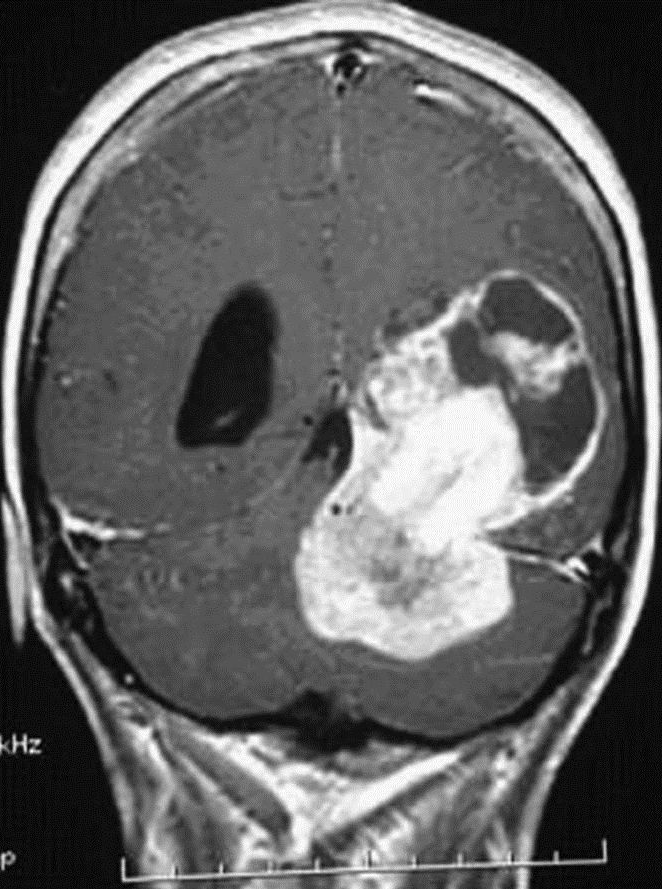

In [17]:
img = cv2.imread('/content/brain_tumor_dataset/yes/Y_1.jpg')
crop_brain_tumor(img, True)

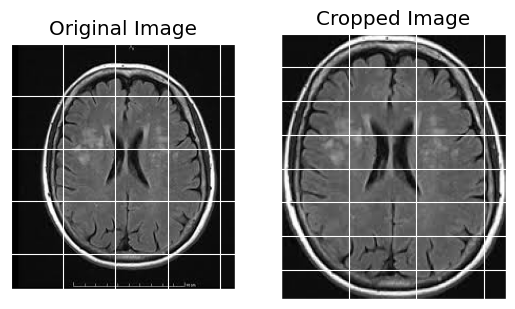

array([[[12, 12, 12],
        [12, 12, 12],
        [12, 12, 12],
        ...,
        [12, 12, 12],
        [12, 12, 12],
        [12, 12, 12]],

       [[12, 12, 12],
        [12, 12, 12],
        [12, 12, 12],
        ...,
        [12, 12, 12],
        [12, 12, 12],
        [12, 12, 12]],

       [[12, 12, 12],
        [12, 12, 12],
        [12, 12, 12],
        ...,
        [12, 12, 12],
        [12, 12, 12],
        [12, 12, 12]],

       ...,

       [[12, 12, 12],
        [12, 12, 12],
        [12, 12, 12],
        ...,
        [11, 11, 11],
        [11, 11, 11],
        [11, 11, 11]],

       [[12, 12, 12],
        [12, 12, 12],
        [12, 12, 12],
        ...,
        [11, 11, 11],
        [11, 11, 11],
        [11, 11, 11]],

       [[12, 12, 12],
        [12, 12, 12],
        [12, 12, 12],
        ...,
        [11, 11, 11],
        [11, 11, 11],
        [11, 11, 11]]], dtype=uint8)
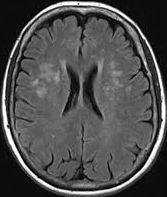

In [18]:
img = cv2.imread('/content/brain_tumor_dataset/no/N_1.jpg')
crop_brain_tumor(img, True)

In [19]:
import os
import cv2

folder1 = '/content/brain_tumor_dataset/no'
folder2 = '/content/brain_tumor_dataset/yes'

for folder in [folder1, folder2]:
    print(f"Checking folder: {folder}")
    for filename in os.listdir(folder):
        filepath = os.path.join(folder, filename)
        img = cv2.imread(filepath)

        if img is None:
            print(f"Error: Could not read {filepath}")  # Debugging output
            continue  # Skip this file

        print(f"Processing {filepath} - Shape: {img.shape}")  # Ensure image is loaded
        img = crop_brain_tumor(img, False)
        cv2.imwrite(filepath, img)


Checking folder: /content/brain_tumor_dataset/no
Processing /content/brain_tumor_dataset/no/aug_N_33_0_6354.jpg - Shape: (664, 550, 3)
Processing /content/brain_tumor_dataset/no/aug_N_52_0_962.jpg - Shape: (275, 220, 3)
Processing /content/brain_tumor_dataset/no/aug_N_85_0_3558.jpg - Shape: (442, 442, 3)
Processing /content/brain_tumor_dataset/no/aug_N_68_0_2920.jpg - Shape: (225, 225, 3)
Processing /content/brain_tumor_dataset/no/aug_N_84_0_3136.jpg - Shape: (340, 339, 3)
Processing /content/brain_tumor_dataset/no/aug_N_75_0_9093.jpg - Shape: (214, 235, 3)
Processing /content/brain_tumor_dataset/no/aug_N_54_0_8640.jpg - Shape: (338, 276, 3)
Processing /content/brain_tumor_dataset/no/aug_N_45_0_6496.jpg - Shape: (244, 206, 3)
Processing /content/brain_tumor_dataset/no/aug_N_69_0_1936.jpg - Shape: (168, 300, 3)
Processing /content/brain_tumor_dataset/no/aug_N_56_0_7106.jpg - Shape: (242, 208, 3)
Processing /content/brain_tumor_dataset/no/aug_N_52_0_3966.jpg - Shape: (275, 220, 3)
Proces

In [20]:
from sklearn.utils import shuffle
def load_data(dir_list, image_size):
    X=[]
    y=[]

    image_width, image_height=image_size

    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory + '/' + filename)
            image = crop_brain_tumor(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation = cv2.INTER_CUBIC)
            image = image/255.00
            X.append(image)
            if directory[-3:] == "yes":
                y.append(1)
            else:
                y.append(0)
    X=np.array(X)
    y=np.array(y)

    X,y = shuffle(X,y)
    print(f"Number of example is : {len(X)}")
    print(f"X SHAPE is : {X.shape}")
    print(f"y SHAPE is : {y.shape}")
    return X,y


In [21]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_data(paths, image_size):
    """
    Load and preprocess images using TensorFlow

    Parameters:
    paths (list): List of paths containing image folders
    image_size (tuple): Target size for images (width, height)

    Returns:
    X (numpy array): Array of processed images
    y (numpy array): Array of labels
    """
    X = []
    y = []

    # Valid image extensions
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp']

    # Loop through each path (yes/no folders)
    for label, path in enumerate(paths):
        print(f"Loading images from {path}")
        for image_name in os.listdir(path):
            # Skip .ipynb_checkpoints directory and any other hidden files
            if image_name.startswith('.') or image_name == '.ipynb_checkpoints':
                continue

            # Check if file has valid image extension
            if not any(image_name.lower().endswith(ext) for ext in valid_extensions):
                continue

            try:
                image_path = os.path.join(path, image_name)
                # Skip if it's a directory
                if os.path.isdir(image_path):
                    continue

                # Load and resize image using tensorflow's utilities
                image = load_img(image_path, target_size=image_size)
                # Convert image to array
                image = img_to_array(image)
                # Normalize pixel values to [0,1]
                image = image / 255.0

                X.append(image)
                y.append(label)

            except Exception as e:
                print(f"Error loading image {image_path}: {str(e)}")

    X = np.array(X)
    y = np.array(y)

    print(f"Loaded {len(X)} images")
    print(f"Data shape: {X.shape}")

    return X, y


augmented_path = '/content/brain_tumor_dataset/'
enlarged_yes = augmented_path + 'yes'
enlarged_no = augmented_path + 'no'
IMAGE_WIDTH, IMAGE_HEIGHT = (224,224)

X, y = load_data([enlarged_yes, enlarged_no], (IMAGE_WIDTH, IMAGE_HEIGHT))

Loading images from /content/brain_tumor_dataset/yes
Loading images from /content/brain_tumor_dataset/no
Loaded 2064 images
Data shape: (2064, 224, 224, 3)


In [22]:
import matplotlib.pyplot as plt

def plot_sample_images(X, y, n=50):

    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False,
                            labelright=False)

            i += 1

        label_to_str = lambda label: "No" if label == 1 else "Yes"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

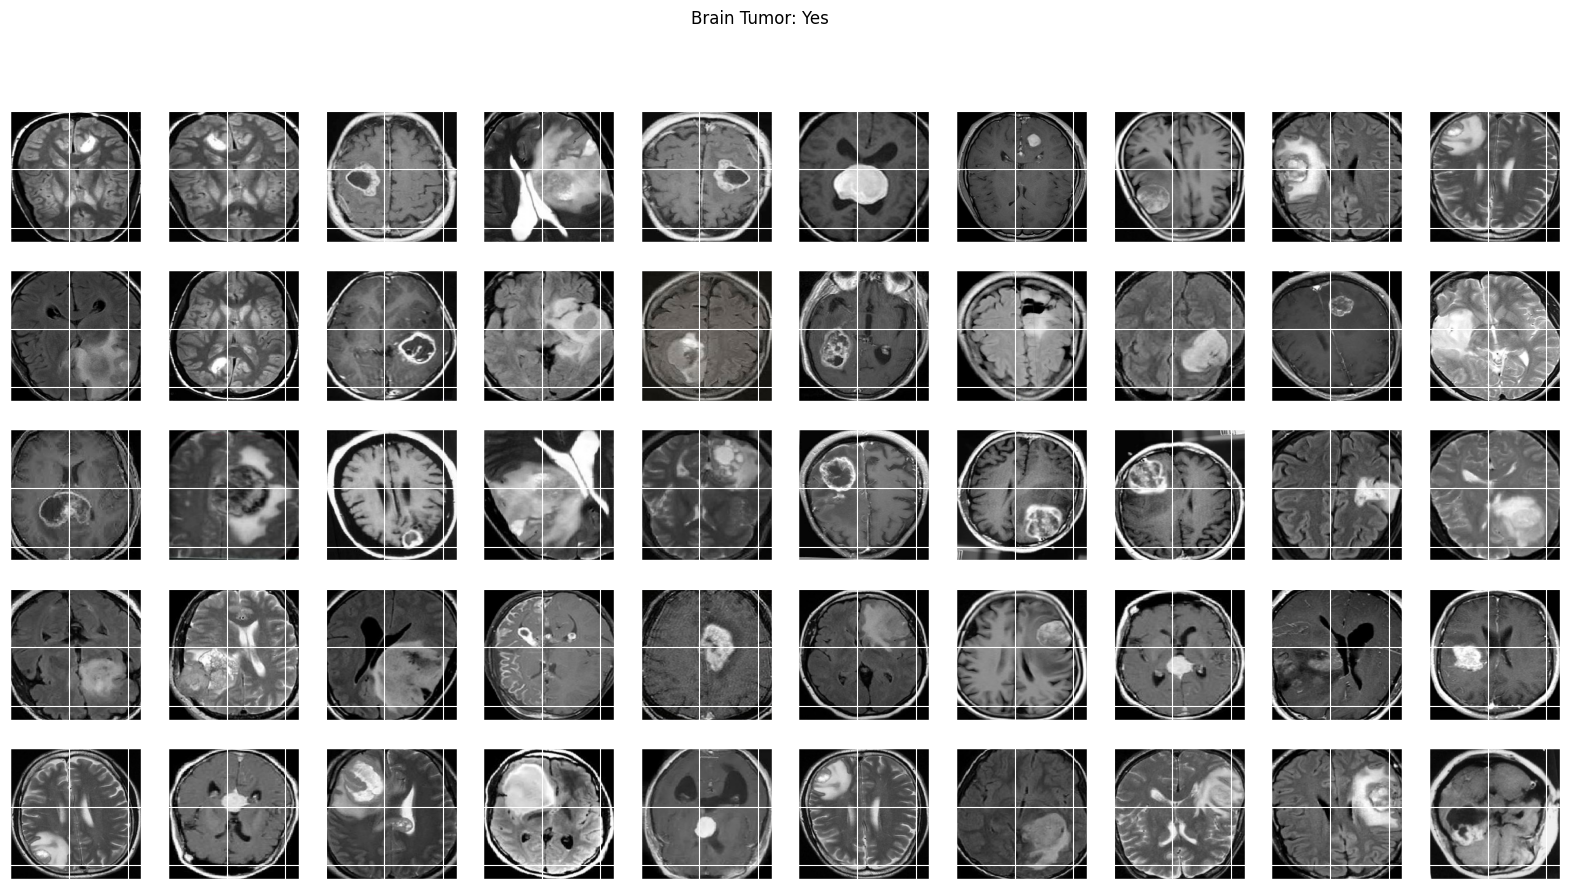

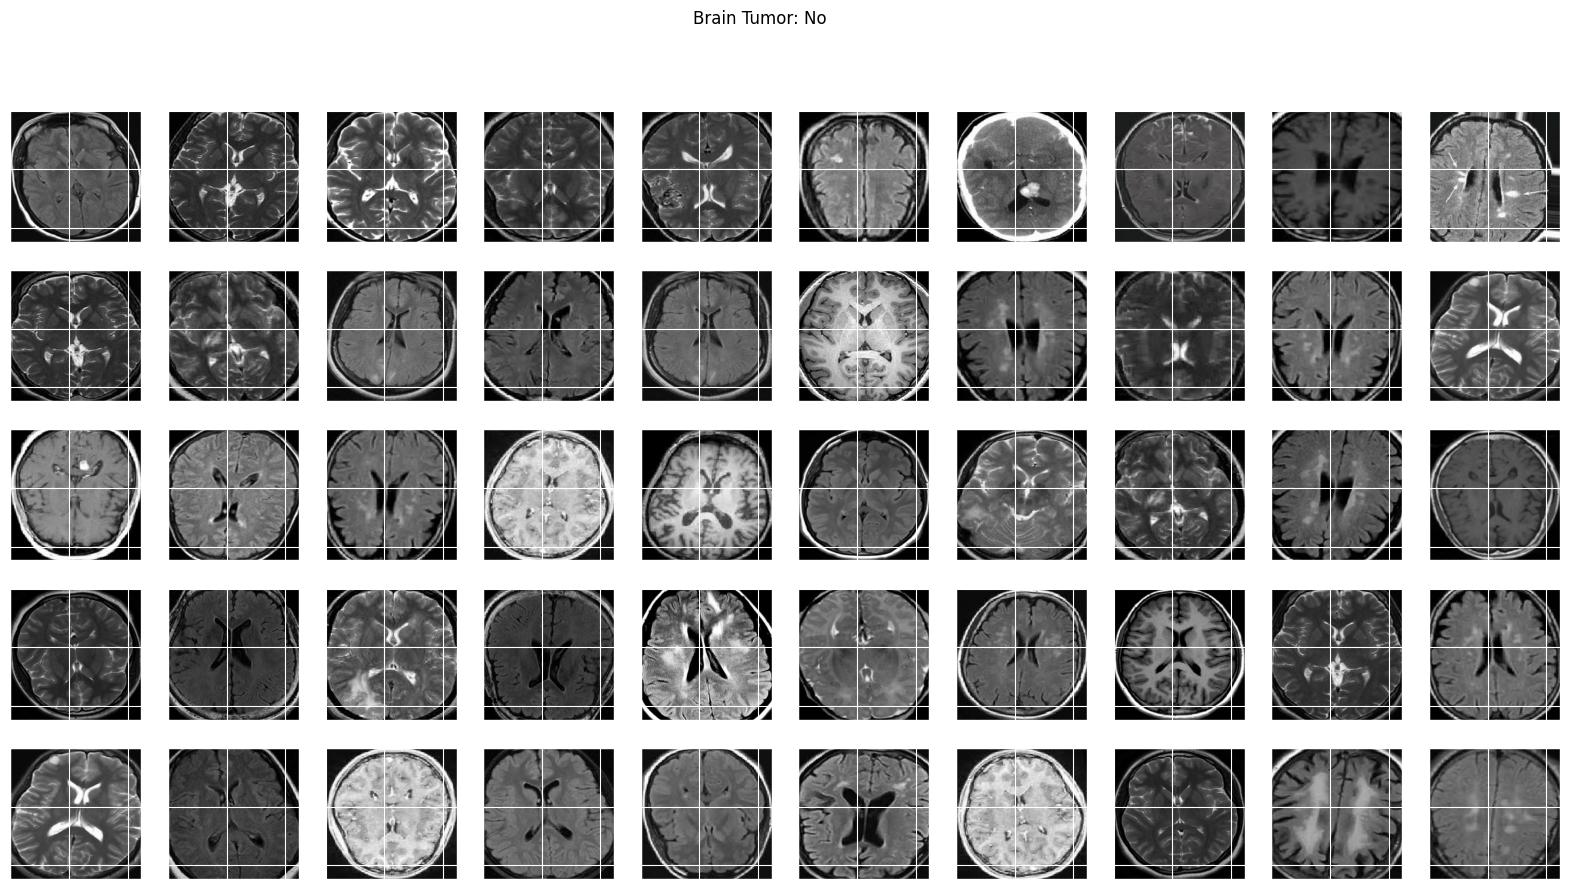

In [23]:
plot_sample_images(X,y)

In [24]:
import pandas as pd
import os
from PIL import Image

# 1. Creating the CSV file
def create_dataset_csv():
    # Initialize lists to store paths and labels
    image_paths = []
    labels = []

    # Define base directory
    base_dir = "/content/brain_tumor_dataset/"

    # For tumor images (yes folder)
    yes_dir = os.path.join(base_dir, "yes")
    for img in os.listdir(yes_dir):
        if img.startswith('aug_Y') and img.endswith('.jpg'):
            img_path = os.path.join(yes_dir, img)
            image_paths.append(img_path)
            labels.append(1)

    # For non-tumor images (no folder)
    no_dir = os.path.join(base_dir, "no")
    for img in os.listdir(no_dir):
        if img.startswith('aug_N') and img.endswith('.jpg'):
            img_path = os.path.join(no_dir, img)
            image_paths.append(img_path)
            labels.append(0)

    # Create DataFrame
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': labels
    })

    # Save to CSV
    df.to_csv('BT_Dataset.csv', index=False)
    print("CSV file created successfully!")
    print(f"Total images processed: {len(df)}")

# 2. Reading headings of CSV file
def read_csv_headers():
    df = pd.read_csv('BT_Dataset.csv')
    print("\nCSV File Headers:")
    print(df.columns.tolist())

# 3. Displaying certain columns
def display_columns():
    df = pd.read_csv('BT_Dataset.csv')
    print("\nFirst 5 rows of the dataset:")
    print(df[['image_path', 'label']].head())
    # Print total number of samples
    print("\nTotal number of samples:", len(df))
    print("Number of tumor cases (yes):", len(df[df['label'] == 1]))
    print("Number of non-tumor cases (no):", len(df[df['label'] == 0]))

# Execute all functions
create_dataset_csv()
read_csv_headers()
display_columns()

CSV file created successfully!
Total images processed: 1811

CSV File Headers:
['image_path', 'label']

First 5 rows of the dataset:
                                          image_path  label
0  /content/brain_tumor_dataset/yes/aug_Y_146_0_9...      1
1  /content/brain_tumor_dataset/yes/aug_Y_32_0_96...      1
2  /content/brain_tumor_dataset/yes/aug_Y_63_0_74...      1
3  /content/brain_tumor_dataset/yes/aug_Y_63_0_54...      1
4  /content/brain_tumor_dataset/yes/aug_Y_33_0_34...      1

Total number of samples: 1811
Number of tumor cases (yes): 930
Number of non-tumor cases (no): 881
